# Cyber-Security Model

## Mean Field Game with Finitely Many States

#### Samuel Babichenko, Alexander Bernstein, Cosmin Borsa, Jimin Lin

In [57]:
import numpy as np
import pandas as pd
from scipy.linalg import expm
import matplotlib.pyplot as plt
from matplotlib import rc
import copy
plt.style.use('seaborn-white')
plt.rcParams['figure.figsize'] = (10, 6)
from tqdm import tqdm, trange

### Abstract

Building on the work of Carmona [1] and Kolokoltsov et al [2], we have implemented a Reinforcement Learning (RL) algorithm for the behavior of computer owners facing cyber attacks. First, we will introduce the model and describe its dynamics. Next, we implement the mean-field game and provide numerical results for different initial conditions. We analyze the response of computer owners against cyber threats, as a stochastic game of a large number of interacting agents. Last, we will introduce a RL algorithm to solve the mean-field game that models the behavior of computer owners. 

### The Model

We assume that any computer can be in four **states**:

- **DI**: Defended and infected
- **DS**: Defended and susceptible to infection
- **UI**: Unprotected and infected 
- **US**: Unprotected and susceptible to infection

Each computer owner may choose one of two **actions**:

- **Action 0**: Maintain status quo

- **Action 1**: Switch to the other state

Updating occurs after an exponential time with parameter $\lambda > 0$, which accounts for the speed of the response of the defense system.

Action 0: The computer owner sticks with its level of defense (Defended or Unprotected)

Action 1: The computer owner updates the level of protection of its computer.
          Unprotected -> Defended
          Defended -> Unprotected

A computer may become **infected** in two ways: 

- **Directly**: From the attacks of the hacker 

- **Indirectly**: From infected computers that spread the infection

**Direct infection** depends on the intensity of the attack $v_{H}$ and the the level of protection of the victim $q_\text{inf}$.

- $v_{H} \cdot q_\text{inf}^D$: Rate of direct infection of a protected computer

- $v_H \cdot q_\text{inf}^U$: Rate of direct infection of an unprotected computer

**Indirect infection** rates depend upon the distribution of states $\mu$:

- $\beta_{UU} \cdot \mu\{UI\}$: Rate of infection of an unprotected susceptible computer by other unprotected infected computers

- $\beta_{UD} \cdot \mu\{UI\}$: Rate of infection of a protected susceptible computer by other unprotected infected computers

- $\beta_{DU} \cdot \mu\{DI\}$: Rate of infection of an unprotected susceptible computer by other protected infected computers

- $\beta_{DD} \cdot \mu\{DI\}$: Rate of infection of a protected susceptible computer by other protected infected computers

Computers **recover** at a rate depending on their protection level:
- $q_{rec}^D$: Recovery rate for a protected computer 
- $q_{rec}^U$: Recovery rate for an unprotected computer

In [18]:
def get_qmat(mu, a, q_inf_U, q_inf_D, q_rec_D, q_rec_U, b_UU, b_UD, b_DU, b_DD, ν_H, la):
    '''
    Get infinitesimal generator matrix given measure and action
    Input:
    mu: dictionary or pd.series like {'DI': 0.25, 'DS': 0.25, 'UI': 0.25, 'US': 0.25}
    a: action in [0, 1]
    Output:
    Q: 4 X 4 matrix
    '''
    if a == 0:
        Q = np.array([
            [-q_rec_D, q_rec_D, 0, 0],
            [ν_H*q_inf_D+b_DD*mu['DI']+b_UD*mu['UI'], -(ν_H*q_inf_D+b_DD*mu['DI']+b_UD*mu['UI']), 0, 0],
            [0, 0, -q_rec_U , q_rec_U],
            [0, 0, ν_H*q_inf_U+b_UU*mu['UI']+b_DU*mu['DI'], -(ν_H*q_inf_U+b_UU*mu['UI']+b_DU*mu['DI'])]   
            ])
    elif a == 1:
        Q = np.array([
            [-(q_rec_D+la), q_rec_D, la, 0],
            [ν_H*q_inf_D+b_DD*mu['DI']+b_UD*mu['UI'], -(ν_H*q_inf_D+b_DD*mu['DI']+b_UD*mu['UI']+la), 0, la],
            [la, 0, -(q_rec_U+la), q_rec_U],
            [0, la, ν_H*q_inf_U+b_UU*mu['UI']+b_DU*mu['DI'], -(ν_H*q_inf_U+b_UU*mu['UI']+b_DU*mu['DI']+la)]   
            ])
    return Q

A computer owner incurs **costs** for defending the system and **losses** for being infected. 
- $k_D$: Fee per unit of time paid for defence 
- $k_I$: Fee per unit of time for losses resulting from infection
 
Consequently, the cost function of the computer owner is given by:

$$f(t, X_t, \mu_t, \alpha_t) = \big(k_D \mathbf{1}_D + k_I \mathbf{1}_I\big)(X_t)$$

where $X_t$ denotes the state of the computer at time $t$, $D = \{\text{DS}, \text{DI}\}$, and $I = \{\text{DI}, \text{UI}\}$.

In [19]:
def get_f(k_D, k_I):
    '''
    Running cost function
    '''
    return np.array([k_D + k_I, k_D, k_I, 0])

## Implementation

### Implementation of the HJB equation

We will first define the **Hamiltonian** as a real valued function

$$H(t, x, \mu, h, \alpha) = \lambda_t(x, \cdot, \mu, \alpha) h(\cdot) + f(t, x, \mu, \alpha) $$

and similarly the **minimized Hamiltonian**

$$H^{\star}(t, x, \mu, h) = \inf_{\alpha \in \mathbb{A}} H(t, x, \mu, h, \alpha) = \inf_{\alpha \in \mathbb{A}} H\big(t, x, \mu, h, \hat{\alpha}(t, x, \mu, h)\big)$$

where $\hat{\alpha}(t, x, \mu, h) = \text{argmin}_{\alpha \in \mathbb{A}} H(t, x, \mu, h, \alpha)$ is the minimizer of $H$ and $\lambda_t (x, \cdot, \mu, \alpha)$ is the rate of transition for the states of a computer in the network.

For a fixed flow of measure $\mu = (\mu_t)_{0 \leq t \leq T}$ we may introduce the **value function**

$$u^{\mu}(t, x) = \inf_{\alpha \in \mathbb{A}_t} \mathbb{E}\bigg[ \int_t^T f(s, X_s, \mu_s, \alpha_s) ds + g(X_T, \mu_T) \mid X_t = x\bigg]$$

and state the **Hamilton-Jacobi-Bellman equation**

$$\partial_t u^{\mu}(t, x) + H^{\star}(t, x, \mu_t, u^{\mu}(t, \cdot)) = 0, \qquad t \in [0, T], x \in E$$

with terminal condition $u^{\mu}(T, x) = g(x, \mu_T)$. Here $E = \{\text{DI, DS, UI, US}\}$.

By the definition of $H^{\star}$ we have 

$$\partial_t u ^\mu(t, x) + \lambda_t(x, \cdot, \mu_t, \hat{\alpha}) u^{\mu}(t, \cdot) + f(x) = 0$$

By **discretizing the HJB equation** using a Euler scheme, we get 

\begin{align}
& \frac{u ^\mu(t+ \delta t, x) - u ^\mu(t, x)}{δt} + \frac{P_{x, \cdot}^{\mu_t, \hat{\alpha}}(\delta t) - P_{x, \cdot}^{\mu_t, \hat{\alpha}}(0)}{\delta t} u^{\mu}(t + \delta t, \cdot) + f(x) = 0 \\
& u ^\mu(t, x) = P_{x, \cdot}^{\mu_t, \hat{\alpha}}(\delta t)u^{\mu}(t + \delta t, \cdot) + f(x) \delta t
\end{align}

where $P_{x, \cdot}^{\mu_t, \hat{\alpha}}(t)$ is the stochastic semigroup corresponding to the generator $\lambda_t(x, \cdot, \mu_t, \hat{\alpha})$. It solves the flow for a given set of initial conditions.

In [20]:
def solve_hjb(mu_flow, param_q, param_f):
    '''
    Solve the HJB equation using discrete dynamic programming 
    '''
    a_space = [0, 1]
    # initialize value function
    u = pd.DataFrame(np.zeros(mu_flow.shape), index=mu_flow.index, columns=mu_flow.columns)         
    # initialize action flow
    a_flow = pd.DataFrame(np.zeros(mu_flow.shape), index=mu_flow.index, columns=mu_flow.columns)    
    # get time step
    dt = mu_flow.index[1]
    f = get_f(**param_f)
    for t in reversed(range(len(u)-1)):
        mu = mu_flow.iloc[t]
        Q = [get_qmat(mu, a, **param_q) for a in a_space]         # Q matrix by mu and action
        P = [expm(q*dt) for q in Q]
        u_t_list = np.vstack([p@u.iloc[t+1] +  f*dt for p in P])  # Halmitonian * dt (7.33)
        u_t_list_min = u_t_list.min(axis=0)                       # min Halmitonian
        a = u_t_list.argmin(axis=0)                               # corresponding action
        u.iloc[t] = u_t_list_min                                  # record value funtion at t
        a_flow.iloc[t] = a                                        # record action at t
    return a_flow, u

### Implementation of the Kolmogorov equation

We will now search for a fixed point of the best response function using the Kolmogorov equation

$$\partial_t \mu_t(x) = \mu_t(\cdot) \lambda_t(\cdot, x, \mu_t, \hat{\alpha})$$

Discretizing the forward Kolmogorov equation by a Euler scheme we get

\begin{align}
& \frac{\mu_{t+ \delta t}(x) - \mu_t(x)}{\delta t} =  \mu_t(\cdot) \frac{P_{\cdot, x}^{\mu_t, \hat{\alpha}}(\delta t) - P_{\cdot, x}^{\mu_t, \hat{\alpha}}(0)}{\delta t} \\
& \mu_{t + \delta t}(x) = \mu_t(\cdot) P_{\cdot, x}^{\mu_t, \hat{\alpha}}(\delta t)
\end{align}

In [21]:
def solve_flow(mu0, a_flow, param_q, param_f):
    mu_flow = pd.DataFrame(np.zeros(a_flow.shape), index=a_flow.index, columns=a_flow.columns)
    mu_flow.iloc[0] = mu0
    t_len, x_len = a_flow.shape
    dt = a_flow.index[1]
    for t in range(t_len-1):
        mu = mu_flow.iloc[t]
        ax = a_flow.iloc[t]
        mu_new = mu @ [expm(get_qmat(mu, ax[x], **param_q) *dt)[x]      # KFP eqn (7.36)
                     for x in range(x_len)]
        mu_flow.iloc[t+1] = mu_new
    return mu_flow

### Fixed-Point Step

To find the Nash equilibria for the finite player game, we need to search for the fixed point of the best response function. The measure flow $\mu = (\mu_t)_{0 \leq t \leq T}$ provides such a fixed point if $\mu_0 = \mathcal{L}(X_0)$ and if $(\mu_t)_{0 \leq t \leq T}$ satisfies the Kolmogorov equation for the marginal law $(\mathcal{L}(X_t))_{0 \le t \leq T}$ of the optimally controlled path $(X_t)_{0 \le t \leq T}$. 

In [22]:
def solve_fixpoint(mu0, param_q, param_f, T=10, n=1000, iterations=1):
    tline = np.linspace(0, T, n+1)
    dt = T/n
    mu_flow = pd.DataFrame(np.random.dirichlet(np.ones(len(mu0)), size=len(tline)), 
                           index=tline, columns=mu0.index)
    a_flow_list = []
    mu_flow_list = []
    for i in range(iterations):
        a_flow, _ = solve_hjb(mu_flow, param_q, param_f)
        mu_flow = solve_flow(mu0, a_flow, param_q, param_f)
        mu_flow_list.append(mu_flow)
        a_flow_list.append(a_flow)
    return (mu_flow_list, a_flow_list)

In [23]:
# Parameters for discretization
T = 10
n = 1000
tline = np.linspace(0, T, n+1)

# Parameters for plot
param_plot={ 'style': ['-', '--', ':', '-.'],
    'color': ['black', 'red', 'green', 'blue'],
    'ylim': [-0.02,1.02],
    'xlim': [-0.2, T+0.2]}

## Numerical Experiments

In [24]:
# Parameter set 1
param_q = {'q_inf_U': 0.3, 'q_inf_D': 0.4, 'q_rec_D': 0.5, 'q_rec_U': 0.4,
           'b_UU': 0.3, 'b_UD': 0.4, 'b_DU': 0.3, 'b_DD': 0.4,'ν_H': 0.6, 'la': 0.8}
param_f = {'k_D': 0.3, 'k_I': 0.5}

# Parameter set 2
param_q2 = {'q_inf_U': 0.3, 'q_inf_D': 0.4, 'q_rec_D': 0.3, 'q_rec_U': 0.3,
            'b_UU': 5, 'b_UD': 5, 'b_DU': 2, 'b_DD': 2, 'ν_H': 0.6, 'la': 100000000}
param_f2 = {'k_D': 0.5385, 'k_I': 1}

Text(0.5, 0, 'time')

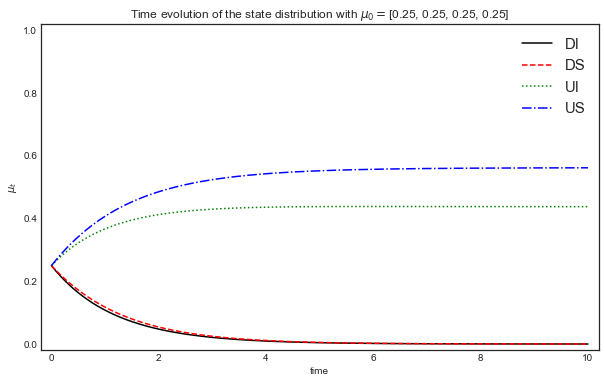

In [34]:
mu0_1 = pd.Series([0.25, 0.25, 0.25, 0.25], index=['DI', 'DS', 'UI', 'US'])
mu_flow_list, a_flow_list = solve_fixpoint(mu0_1, param_q, param_f)
mu_flow_list[-1].plot(**param_plot)
plt.title(r'Time evolution of the state distribution with '+ '$\mu_0 =$' + str(mu0_1.values.tolist()))
plt.legend(fontsize=15)
plt.ylabel(r'$\mu_t$')
plt.xlabel('Time')

Text(0.5, 0, 'time')

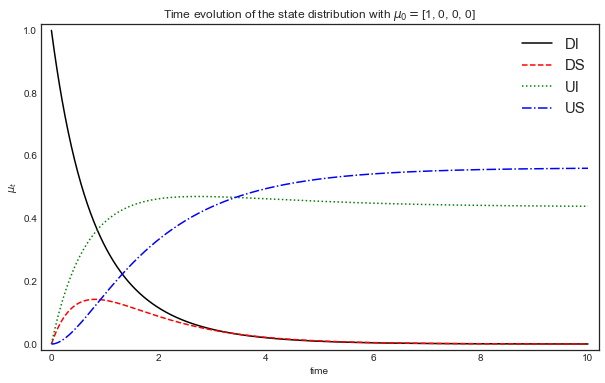

In [35]:
mu0_2 = pd.Series([1, 0, 0, 0], index=['DI', 'DS', 'UI', 'US'])
mu_flow_list, a_flow_list = solve_fixpoint(mu0_2, param_q, param_f)
mu_flow_list[-1].plot(**param_plot)
plt.title(r'Time evolution of the state distribution with '+ '$\mu_0 =$' + str(mu0_2.values.tolist()))
plt.legend(fontsize=15)
plt.ylabel(r'$\mu_t$')
plt.xlabel('Time')

Text(0.5, 0, 'time')

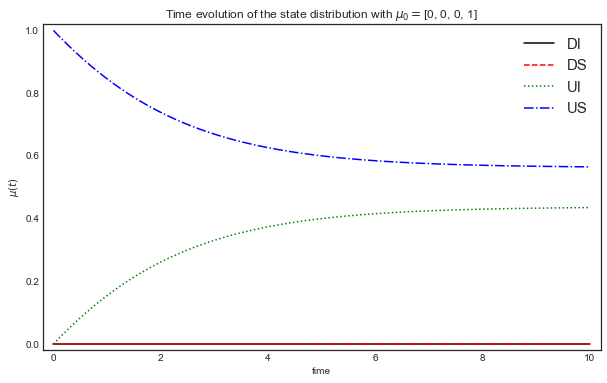

In [33]:
mu0_3 = pd.Series([0, 0, 0, 1], index=['DI', 'DS', 'UI', 'US'])
mu_flow_list, a_flow_list = solve_fixpoint(mu0_3, param_q, param_f)
mu_flow_list[-1].plot(**param_plot)
plt.title(r'Time evolution of the state distribution with '+'$\mu_0 =$'+str(mu0_3.values.tolist()))
plt.legend(fontsize=15)
plt.ylabel(r'$\mu_t$')
plt.xlabel('time')

###  Optimal Feedback

Next, we plot the time evolution of the optimal feedback function $\phi(t, \cdot)$. Irrespective of the initial distribution $\mu_0$ or the parameters of the model, the function $\phi(t, \cdot)$ is constant for all $t \in [0, T]$: 
- $\phi(t, \text{DI}) = \phi(t, \text{DS}) = 1$ 
- $\phi(t, \text{UI}) = \phi(t, \text{US}) = 0$
[//]: # "The reason $a(T,x) = 0$ at the right end is because $g(X_T) \equiv 0$ and action doesn't matter."

Text(0.5, 0, 'time')

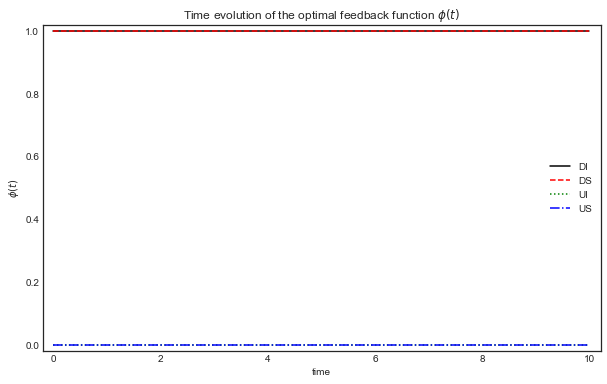

In [58]:
a_flow_list[-1].iloc[:-2,:].plot(**param_plot);
plt.title(r'Time evolution of the optimal feedback function $\phi(t)$')
plt.ylabel(r'$\phi(t)$')
plt.xlabel('time')

### Iteration

We tried to iterated the solutions of the equations to find the fixed point, but we were unable to obtain the results from Chaper 7.2.3 in Carmona [1].

Text(0.5, 0, 'Time')

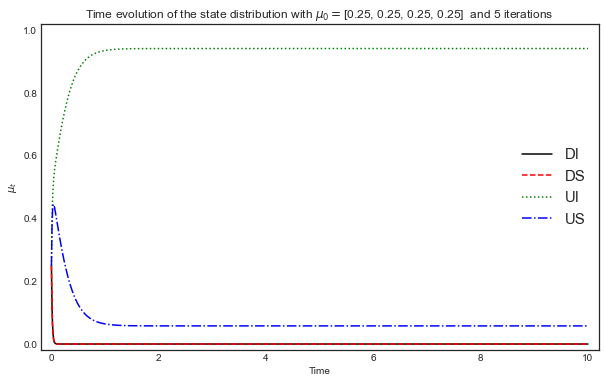

In [64]:
mu0_1 = pd.Series([0.25, 0.25, 0.25, 0.25], index=['DI', 'DS', 'UI', 'US'])
mu_flow_list, a_flow_list = solve_fixpoint(mu0_1, param_q2, param_f2, iterations=5)
mu_flow_list[0].plot(**param_plot)
plt.title(r'Time evolution of the state distribution with '+ '$\mu_0 =$' + str(mu0_1.values.tolist()) + '  and 5 iterations');
plt.legend(fontsize=15)
plt.ylabel(r'$\mu_t$')
plt.xlabel(r'Time')

## Reinforcement Learning

In [73]:
T = 10
n = 100
dt = T/n
tline = np.linspace(0, T, n+1)

f = get_f(**param_f)
X_mat = np.identity(4)
E = ['DI', 'DS', 'UI', 'US']
A = [0,1]
omega_q = 0.9
omega_mu = 0.6
epsilon = 0.95

# ----------- Initialization -----------
q_table = pd.DataFrame(0, index=['DI', 'DS', 'UI', 'US'], columns=A)
mu_flow = pd.DataFrame(1/4, index=tline, columns=['DI', 'DS', 'UI', 'US'])
# mu_flow = pd.DataFrame(0, index=tline, columns=['DI', 'DS', 'UI', 'US'])
# mu_flow.iloc[:,0] = 1

# make rho table
rho_x_df = pd.DataFrame(0, index=tline, columns=[])
rho_a_df = pd.DataFrame(0, index=tline, columns=[])
p_x_a_df = pd.DataFrame(1, index=E, columns=A)

In [74]:
for k in trange(1000,  desc='episode  '):
    q_table_new = copy.deepcopy(q_table)
    mu_flow_new = copy.deepcopy(mu_flow) 
    
    # rho table for determining learning rate
    rho_x_df[k] =  pd.Series(0, index=tline)
    rho_a_df[k] =  pd.Series(0, index=tline)
    x_t1 = np.random.choice(range(4), p=mu_flow.iloc[0])
    # t iteration
    for t in tqdm(range(1,len(tline)), position=0, leave=False, desc='episode {}'.format(k)):
        # ----------- Sample X_t from mu_t -----------
        x_t = x_t1          # should we use t=0 or t=T as in the paper?

        # ----------- update mu_t -----------
        rho_mu = 1/(1+(k+1))**omega_mu                                      # mu learning rate
        mu_t = mu_flow.iloc[t] + rho_mu*(X_mat[x_t] - mu_flow.iloc[t])
        mu_flow_new.iloc[t] = mu_t



        # ----------- choose action a_t         -----------
        q_min_list = np.min(q_table_new.T.values, axis=0)
        a_min_list = np.argmin(q_table_new.T.values, axis=0)

        # choose action
        if np.random.uniform() <= epsilon:
            a_t = a_min_list[x_t]
        else:
            a_t = np.random.choice(A)
            
        # determin learning rate
        rho_x_df.iloc[t, k] = x_t
        rho_a_df.iloc[t, k] = a_t
        p_x_a_df.iloc[x_t, a_t] += 1                                # add count 
        rho_q_count = p_x_a_df.iloc[x_t, a_t]                         # q learning rate
        rho_q = 1/(1 + rho_q_count)**omega_q

        
        # ----------- observe new state and cost -----------
        P = expm(get_qmat(mu_t, a_t, **param_q) * dt)
        x_t1 = np.random.choice(range(4), p=P[x_t, :])
        
        # ----------- update q table -----------
        q_table_new.iloc[x_t, a_t] = (q_table_new.iloc[x_t, a_t] + 
                                      rho_q * (f[x_t1]*dt + q_table_new.iloc[x_t1, a_min_list[x_t1]] - q_table_new.iloc[x_t, a_t]))

    mu_flow = mu_flow_new
#     mu_flow.iloc[0] = [1,0,0,0]                                           # should we use fix mu_0????
    q_table = q_table_new

episode  : 100%|██████████| 1000/1000 [04:13<00:00,  3.95it/s] 


,0,1
DI,0.754687,0.754992
DS,0.364188,0.364088
UI,0.594260,0.594270
US,0.141207,0.149111


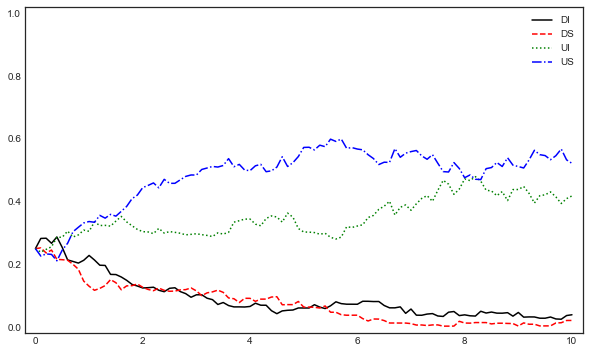

In [76]:
mu_flow.plot(**param_plot)

# mu_flow.plot(**param_plot) # from last large iteration

q_table

## References

[//]: # "MLA 8"

[1] Carmona, René et al. Probabilistic Theory of Mean Field Games with Applications I: Mean Field FBSDEs, Control, and Games. Vol. 83, Springer International Publishing, 2018.

[2] Kolokoltsov, V., and N. Bensoussan. “Mean-Field-Game Model for Botnet Defense in Cyber-Security.” Applied Mathematics & Optimization, vol. 74, no. 3, 2016, pp. 669–692.